# Neoclassical growth model in discrete time: Closed Form
## Greenwood-Hercowitz-Huffman preference

###### First written: December 7, 2019
###### Update: December 18, 2019

## Introduction

There are two well known closed form solutions for the neoclassical growth model in discrete time. The first, and might be the most well-known example, is discussed, for instance, in Ljungqvist and Sargent (2018). In this notebook, we aim to solve the second example where the social planner maximizes his infinite time horizon utility subject to the budget constraint with full capital depreciation.

\begin{align}
& \max \sum_{t=0}^{\infty}\beta^{t}\ln \left(C_{t} -\psi N_{t}^{\theta}\right) \\
\text{s.t.} \quad & K_{t+1} + C_{t} \leq A K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

where the utility function follows the classical Greenwood–Hercowitz–Huffman preference (Greenwood et al. (1988)).

The above neoclassical growth model is known to have a closed form solution for the capital stock in the next period as well as the optimal consumption policy.

\begin{align}
& K_{t+1} = \alpha \beta A K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& C_{t} = \left(1-\alpha \beta \right) A K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

The aim of this notebook is to numerically approximate the above optimal policy functions by using the Gaussian process regression based on the `GPyTorch` library.

## Analytical solutions

We compute the stationary point at first, then we plot the optimal policy functions.
Before doing so, we import some numerical libraries and define economic parameters. Note that we use the `GPyTorch` library to regress the optimal policy functions based on the Gaussian process and `IPOPT` to solve the system of non-linear equations.

In [1]:
import sys
import warnings
import numpy as np
import torch
import gpytorch
import pyipopt
from scipy.optimize import root
# plot
import matplotlib.pyplot as plt
from matplotlib import rc
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

np.random.seed(0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# --------------------------------------------------------------------------- #
# Parameter setting
# No TFP shock, deterministic model
# --------------------------------------------------------------------------- #
A = 1  # Technology level
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.95  # Discount factor
psi = 0.25  # Coefficient of leisure in the utility function
theta = 1.5  # Elasticity of leisure in the utility function

We compute the analytical policy functions of the given model.

In [3]:
# --------------------------------------------------------------------------- #
# Analytical solution
# --------------------------------------------------------------------------- #
def ls_compute(k, A=A, alpha=alpha, psi=psi, theta=theta):
    """ Return the optimal labor supply """
    return (((1-alpha) * A * k**alpha) / (psi*theta))**(1 / (theta+alpha-1))


def kplus_compute_analytic(
        k, A=A, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal capital stock in the next period """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return alpha * beta * A * k**alpha * _ls**(1-alpha)


def c_compute_analytic(k, A=A, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal consumption policy """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return (1 - alpha*beta)*A*k**alpha*_ls**(1-alpha)


def k_infty_compute(k_infty):
    """ Compute the stationary point in capital """
    return k_infty - kplus_compute_analytic(k_infty)


# Find the stationary point
res = root(k_infty_compute, x0=1, method='hybr')
print("Stationary point is {:5f}".format(res.x[0]))

Stationary point is 0.162927


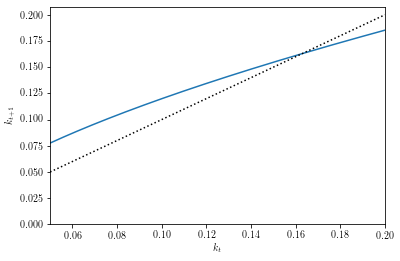

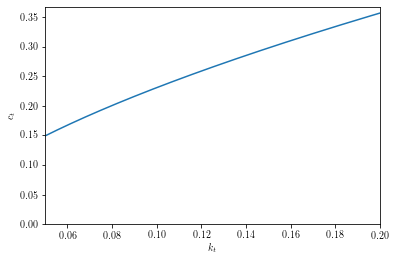

In [4]:
# --------------------------------------------------------------------------- #
# Plot the initial guess
# --------------------------------------------------------------------------- #
kbeg, kend = 0.05, 0.2
grid_plt = 250
kgrid_plt = np.linspace(kbeg, kend, grid_plt)

# Plot the kplus policy function
plt.plot(kgrid_plt, kplus_compute_analytic(kgrid_plt))
plt.plot(kgrid_plt, kgrid_plt, 'k:')
plt.xlabel(r'$k_{t}$')
plt.ylabel(r'$k_{t+1}$')
plt.xlim([kbeg, kend])
plt.ylim([0, None])
plt.show()

# Plot the consumption policy function
plt.plot(kgrid_plt, c_compute_analytic(kgrid_plt))
plt.xlabel(r'$k_{t}$')
plt.ylabel(r'$c_{t}$')
plt.xlim([kbeg, kend])
plt.ylim([0, None])
plt.show()

## Time iteration collocation with the Gaussian process

Here we aim to numerically solve the neoclassical growth model with the Gaussian process regression. Firstly, we solve the model for the first-order conditions:

\begin{align}
& \lambda_{t} - \beta \lambda_{t+1} \alpha A K_{t+1}^{\alpha-1}N_{t+1}^{1-\alpha} = 0 \label{eq:foc_kplus}\\
& A K_{t}^{\alpha}N_{t}^{1-\alpha} - C_{t} - K_{t+1} = 0 \label{eq:foc_rsc}
\end{align}

where $\lambda_{t}$ is the Lagrange multiplier associated with the resource constraint. By substituting \eqref{eq:foc_rsc} to \eqref{eq:foc_kplus}, our task is to solve the equation for the Lagrange multiplier. Note that the resource constraint is always binding as the marginal utility is positive, the corresponding Lagrange multiplier $\lambda_{t}$ always takes a positive value.

Hereafter, we solve the system of non-linear equation by using the time iteration collocation.We at first instantiate and initialize the Gaussian process regressor.

In [5]:
# --------------------------------------------------------------------------- #
# Gaussian process, training and test dataset
# --------------------------------------------------------------------------- #
num_train = 25  # Number of training samples
num_test = 1000  # Number of test samples


def y_train_guess(x_train):
    """ Initialize training outputs """
    _y_train_kplus = x_train
    _y_train_ls = ls_compute(_y_train_kplus)
    _y_train_c = A * x_train**alpha * _y_train_ls**(1-alpha) - x_train
    _y_train_lambd = 1 / (_y_train_c - psi * _y_train_ls**theta)
    return _y_train_kplus, _y_train_lambd


# Training datasets, assuming a uniform distribution
train_x = torch.linspace(kbeg, kend, num_train, dtype=torch.float64)
train_y_kplus, train_y_lambd = y_train_guess(train_x)

### Gaussian process regression

We use the RBF kernel and instantiate the Gaussian process.

In [6]:
# --------------------------------------------------------------------------- #
# Instantiate and initialize the Gaussian process
# Use the GPyTorch library
# --------------------------------------------------------------------------- #
# Define the Gaussian process model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, trian_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_kplus = ExactGPModel(train_x, train_y_kplus, likelihood)
gp_lambd = ExactGPModel(train_x, train_y_lambd, likelihood)

Firstly, we are interested in the Gaussian process regression without hyperparameters optimization and plot distributions.

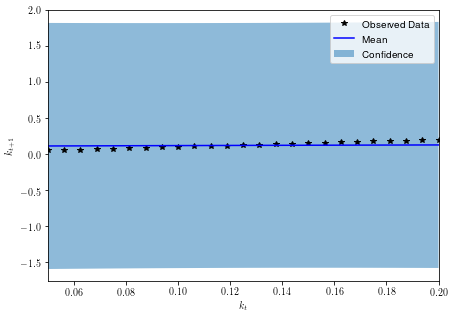

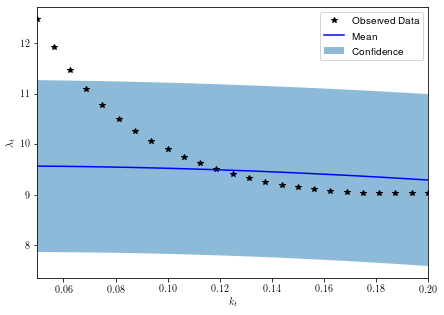

In [7]:
# --------------------------------------------------------------------------- #
# Plot the posterior distirubtion without the hyperparameters optimization
# --------------------------------------------------------------------------- #
# Get into evaluation (predictive posterior) mode
gp_kplus.eval()
gp_lambd.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_x = torch.linspace(kbeg, kend, 50, dtype=torch.float64)
    observed_pred_kplus = likelihood(gp_kplus(plot_x))
    observed_pred_lambd = likelihood(gp_lambd(plot_x))

with torch.no_grad():
    # Initialize plot for kplus
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_kplus.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y_kplus.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(plot_x.numpy(), observed_pred_kplus.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$k_{t+1}$")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()
    
    # Initialize plot for lambda
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_lambd.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y_lambd.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(plot_x.numpy(), observed_pred_lambd.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$\lambda_{t}$")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

As seen above, the Gaussian processes without the hyperparameters optimization present a poor fitting. We need to optimize the hyperparameters in the following way where we use the `PyTorch`'s gradient decent optimizer `adam`.

In [8]:
# --------------------------------------------------------------------------- #
# Find the optimal model hyperparameters
# Train the model with the Adam optimizer
# --------------------------------------------------------------------------- #
gp_kplus.train()
gp_lambd.train()
likelihood.train()

learning_rate = 0.1  # Learning rate
training_iter = 250  # Number of trainings

# Use the adam optimizer
optimizer_kplus = torch.optim.Adam([
    # Includes GaussianLikelihood parameters
    {'params': gp_kplus.parameters()}, ], lr=learning_rate)
optimizer_lambd = torch.optim.Adam([
    # Includes GaussianLikelihood parameters
    {'params': gp_lambd.parameters()}, ], lr=learning_rate)

# "Loss" for GPs - the marginal log likelihood
mll_kplus = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_kplus)
mll_lambd = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_lambd)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_kplus.zero_grad()
    optimizer_lambd.zero_grad()
    # Output from model
    output_kplus = gp_kplus(train_x)
    output_lambd = gp_lambd(train_x)
    # Calculate loss and backprop gradients
    loss_kplus = - mll_kplus(output_kplus, train_y_kplus)
    loss_lambd = - mll_lambd(output_lambd, train_y_lambd)
    loss_kplus.backward()
    loss_lambd.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss_lambd.item(),
        gp_lambd.covar_module.base_kernel.lengthscale.item(),
        gp_lambd.likelihood.noise.item()
    ))
    optimizer_kplus.step()  # Take a step on the optimizer
    optimizer_lambd.step()  # Take a step on the optimizer

Iter 1/250 - Loss: 4.154   lengthscale: 0.693   noise: 0.693
Iter 2/250 - Loss: 3.952   lengthscale: 0.644   noise: 0.598
Iter 3/250 - Loss: 3.771   lengthscale: 0.599   noise: 0.513
Iter 4/250 - Loss: 3.609   lengthscale: 0.558   noise: 0.439
Iter 5/250 - Loss: 3.459   lengthscale: 0.519   noise: 0.374
Iter 6/250 - Loss: 3.318   lengthscale: 0.483   noise: 0.317
Iter 7/250 - Loss: 3.180   lengthscale: 0.448   noise: 0.269
Iter 8/250 - Loss: 3.048   lengthscale: 0.415   noise: 0.227
Iter 9/250 - Loss: 2.927   lengthscale: 0.383   noise: 0.192
Iter 10/250 - Loss: 2.825   lengthscale: 0.353   noise: 0.162
Iter 11/250 - Loss: 2.750   lengthscale: 0.324   noise: 0.138
Iter 12/250 - Loss: 2.696   lengthscale: 0.297   noise: 0.121
Iter 13/250 - Loss: 2.639   lengthscale: 0.274   noise: 0.112
Iter 14/250 - Loss: 2.562   lengthscale: 0.254   noise: 0.110
Iter 15/250 - Loss: 2.468   lengthscale: 0.237   noise: 0.112
Iter 16/250 - Loss: 2.366   lengthscale: 0.223   noise: 0.117
Iter 17/250 - Los

Iter 154/250 - Loss: -1.963   lengthscale: 0.048   noise: 0.000
Iter 155/250 - Loss: -1.964   lengthscale: 0.048   noise: 0.000
Iter 156/250 - Loss: -1.966   lengthscale: 0.048   noise: 0.000
Iter 157/250 - Loss: -1.967   lengthscale: 0.048   noise: 0.000
Iter 158/250 - Loss: -1.969   lengthscale: 0.048   noise: 0.000
Iter 159/250 - Loss: -1.970   lengthscale: 0.048   noise: 0.000
Iter 160/250 - Loss: -1.971   lengthscale: 0.048   noise: 0.000
Iter 161/250 - Loss: -1.972   lengthscale: 0.048   noise: 0.000
Iter 162/250 - Loss: -1.974   lengthscale: 0.048   noise: 0.000
Iter 163/250 - Loss: -1.975   lengthscale: 0.048   noise: 0.000
Iter 164/250 - Loss: -1.976   lengthscale: 0.048   noise: 0.000
Iter 165/250 - Loss: -1.977   lengthscale: 0.048   noise: 0.000
Iter 166/250 - Loss: -1.978   lengthscale: 0.048   noise: 0.000
Iter 167/250 - Loss: -1.980   lengthscale: 0.049   noise: 0.000
Iter 168/250 - Loss: -1.981   lengthscale: 0.049   noise: 0.000
Iter 169/250 - Loss: -1.982   lengthscal

Then plot the posterior distributions.

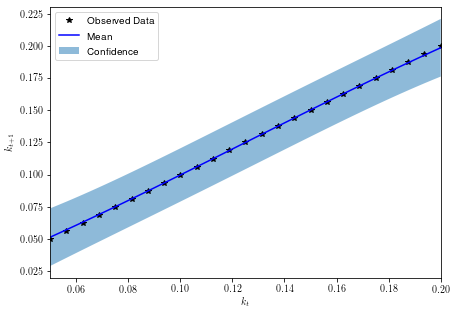

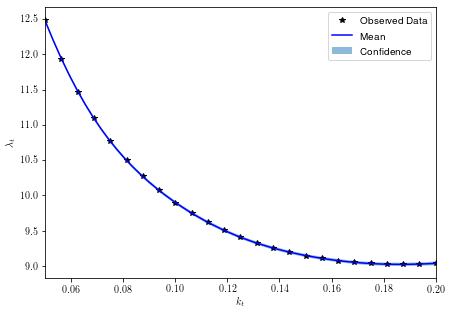

In [9]:
# --------------------------------------------------------------------------- #
# Get into evaluation (predictive posterior) mode to plot the posterior
# distribution.
# --------------------------------------------------------------------------- #
gp_kplus.eval()
gp_lambd.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_x = torch.linspace(kbeg, kend, 50, dtype=torch.float64)
    observed_pred_kplus = likelihood(gp_kplus(plot_x))
    observed_pred_lambd = likelihood(gp_lambd(plot_x))

with torch.no_grad():
    # Initialize plot for kplus
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_kplus.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y_kplus.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(plot_x.numpy(), observed_pred_kplus.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$k_{t+1}$")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

    # Initialize plot for lambda
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_lambd.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y_lambd.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(plot_x.numpy(), observed_pred_lambd.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$\lambda_{t}$")
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

## Define the equilibrium conditions

In [10]:
# --------------------------------------------------------------------------- #
# Equilibrium conditions
# --------------------------------------------------------------------------- #
def euler(x0, k, gp_lambd, likelihood):
    """
    Set of non-linear equilibrium conditions solved by IPOPT
    x0: Starting values for the optimization
    k: Current capital state
    x[0]: lambda, Lagrange multiplier associated with the budget constraint
    """

    nvar = 1  # Number of variables

    # All of plicies are assumed to be non-negative
    x_L = np.zeros(nvar, dtype=np.float64)
    x_U = np.ones(nvar, dtype=np.float64) * np.inf

    def ls_compute(k):
        """ Return the optimal labor supply """
        return (((1-alpha) * A * k**alpha) / (psi*theta))**(
            1 / (theta+alpha-1))

    ls = ls_compute(k)  # Current labor supply

    def con_compute(x):
        """ Consumption
        x[0]: lambda """
        return 1 / x[0] + psi * ls**theta

    def kplus_compute(x):
        """ Capital stock in the next period """
        return A * k**alpha*ls**(1-alpha) - con_compute(x)

    def ls_plus(x):
        """ Labor supply in the next period """
        return ls_compute(kplus_compute(x))

    def lambdplus(x):
        """ Return lambda (the Lagrange multiplier) in the next period """
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            state = torch.tensor([kplus_compute(x)], dtype=torch.float64)
            observed_pred = gp_lambd(state)
            return observed_pred.mean.numpy()

    def eval_f(x):
        """ Dummy objective function """
        assert len(x) == nvar
        return 0

    def eval_grad_f(x):
        """ Gradient of the dummy objective function """
        assert len(x) == nvar
        grad_f = np.zeros(nvar, dtype=np.float64)
        return grad_f

    ncon = nvar  # Number of constraints

    """ Equilibrium condition
    g0: Euler equation wrt. k_{t+1}
    """

    g_L = np.zeros(ncon, dtype=np.float64)
    g_U = g_L

    nnzj = int(nvar * ncon)  # Number of (possibly) non-zeros in Jacobian
    nnzh = int((nvar**2 - nvar) / 2 + nvar)  # Number of non-zeros in Hessian

    def eval_g(x):
        """ The system of non-linear equilibrium conditions """
        assert len(x) == nvar

        g0 = x[0] - beta * lambdplus(x) * A * alpha * kplus_compute(x)**(
            alpha-1) * ls_plus(x)**(1-alpha)
        # g1 = x[1] * (A * k**alpha * ls**(1-alpha) - x[0] - con(x, ls))
        return np.array([g0])

    def eval_jac_g(x, flag):
        """ Numerical approximation of the Jacobian of the system of
        non-linear equilibrium conditions
        Use the finite-difference-values option provided by IPOPT """
        assert len(x) == nvar

        row_idx = np.empty(nnzj, dtype=int)  # Row index
        col_idx = np.empty(nnzj, dtype=int)  # Column index

        # Jacobian matrix structure
        if flag:
            for i in range(ncon):
                for j in range(nvar):
                    row_idx[j + i * nvar] = i
                    col_idx[j + i * nvar] = j

            return (row_idx, col_idx)

    # ----------------------------------------------------------------------- #
    # Define a NLP model
    # ----------------------------------------------------------------------- #
    pyipopt.set_loglevel(0)  # Let IPOPT quite

    neoclassical = pyipopt.create(
        nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f,
        eval_g, eval_jac_g)
    neoclassical.str_option("linear_solver", "ma57")
    neoclassical.str_option(
        "jacobian_approximation", "finite-difference-values")
    neoclassical.str_option("hessian_approximation", "limited-memory")
    neoclassical.int_option("print_level", 1)

    xstar, zl, zu, constraint_multipliers, obj, status = neoclassical.solve(x0)

    if status != 0:
        warnings.warn(
            "IPOPT fails to solve the system of non-linear equations. "
            "Use the starting value as the solution instead.")
        xstar = x0
    return xstar

Then we numerically approximate the policy function using the time iteration collocation with the Gaussian process.

In [11]:
# --------------------------------------------------------------------------- #
# Time iteration collocation
# --------------------------------------------------------------------------- #
def time_iter_gp(num_train, training_iter):
    """
    Time iteration collocation with the Gaussian process regression
    num_train: Number of training examples
    """
    num_iter = 1000  # Number of time iterations
    epsilons = []  # Track the approximation error
    epsilon_tol = 1e-6  # Convergence tolrance

    # ----------------------------------------------------------------------- #
    # Generate a training dataset, uniform distribution
    # ----------------------------------------------------------------------- #
    train_x = torch.linspace(kbeg, kend, num_train, dtype=torch.float64)
    train_y_kplus, train_y_lambd = y_train_guess(train_x)

    # ----------------------------------------------------------------------- #
    # Instantiate and initialize the Gaussian process
    # ----------------------------------------------------------------------- #
    # Define the Gaussian process model
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, trian_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp_kplus = ExactGPModel(train_x, train_y_kplus, likelihood)
    gp_lambd = ExactGPModel(train_x, train_y_lambd, likelihood)

    # ----------------------------------------------------------------------- #
    # Find optimal model hyperparameters
    # ----------------------------------------------------------------------- #
    gp_kplus.train()
    gp_lambd.train()
    likelihood.train()

    # Use the adam optimizer
    learning_rate = 0.1
    optimizer_kplus = torch.optim.Adam([
        # Includes GaussianLikelihood parameters
        {'params': gp_kplus.parameters()}, ], lr=learning_rate)
    optimizer_lambd = torch.optim.Adam([
        # Includes GaussianLikelihood parameters
        {'params': gp_lambd.parameters()}, ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll_kplus = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_kplus)
    mll_lambd = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_lambd)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer_kplus.zero_grad()
        optimizer_lambd.zero_grad()
        # Output from model
        output_kplus = gp_kplus(train_x)
        output_lambd = gp_lambd(train_x)
        # Calculate loss and backprop gradients
        loss_kplus = - mll_kplus(output_kplus, train_y_kplus)
        loss_lambd = - mll_lambd(output_lambd, train_y_lambd)
        # Call backward on the loss to fill in gradients
        loss_kplus.backward()
        loss_lambd.backward()
        # Take one step on the optimizer
        optimizer_kplus.step()
        optimizer_lambd.step()

    # sys.exit(0)
    # ----------------------------------------------------------------------- #
    # Time iteration collocation
    # ----------------------------------------------------------------------- #
    for n in range(1, num_iter+1):
        # Starting value retliving from the previous optimization
        x0 = train_y_lambd.numpy()[:, None]

        # Get into evaluation (predictive posterior) mode
        gp_lambd.eval()
        likelihood.eval()

        # Keep the optimal policies
        train_y_lambd = np.empty_like(train_y_kplus)

        for idx, k in enumerate(train_x.numpy()):
            # For each state, solve the system of non-linear equations
            xstar = euler(x0[idx], k, gp_lambd, likelihood)
            # Track the optimal policies
            train_y_lambd[idx] = xstar
            # print(xstar)
            # sys.exit(0)
        # ------------------------------------------------------------------- #
        # Train the Gaussian process with the optimal policy
        # ------------------------------------------------------------------- #
        # Training data
        train_y_lambd = torch.from_numpy(train_y_lambd)
        gp_lambd_update = ExactGPModel(train_x, train_y_lambd, likelihood)
        # Switch to the training mode
        gp_lambd_update.train()
        likelihood.train()

        optimizer_lambd_update = torch.optim.Adam([
            # Includes GaussianLikelihood parameters
            {'params': gp_lambd_update.parameters()}, ], lr=learning_rate)

        mll_lambd_update = gpytorch.mlls.ExactMarginalLogLikelihood(
            likelihood, gp_lambd_update)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer_lambd_update.zero_grad()
            # Output from model
            output_lambd_update = gp_lambd_update(train_x)
            loss_lambd_updated = - mll_lambd_update(
                output_lambd_update, train_y_lambd)
            # Call backward on the loss to fill in gradients
            loss_lambd_updated.backward()
            # Take one step on the optimizer
            optimizer_lambd_update.step()

        # ------------------------------------------------------------------- #
        # Approximation error analysis
        # Update the policy functions for the next iteration
        # ------------------------------------------------------------------- #
        # Switch to the evaluation mode
        gp_lambd.eval()
        gp_lambd_update.eval()
        likelihood.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Test datasets, used to evaluate the approximation quality
            test_x = torch.linspace(kbeg, kend, num_test, dtype=torch.float64)
            observed_pred = likelihood(gp_lambd(test_x))
            observed_pred_update = likelihood(gp_lambd_update(test_x))

            epsilon = np.max(np.abs(
                observed_pred.mean.numpy() - observed_pred_update.mean.numpy()
            ))
        epsilons.append(epsilon)  # Track the history of epsilon

        # sys.exit(0)
        if n % 1 == 0:
            print('Iteration: {}, Approximation error: {:.3e}'.format(
                n, epsilons[-1]))

        if epsilons[-1] < epsilon_tol:
            # Terminate the time iteration and save the optimal surrogates
            gp_lambd_star = gp_lambd_update
            print("Time iteration collocation is terminated successfuly with "
                  "{} iterations".format(n))
            break  # Terminate the iteration

        else:
            # Update the GP with the surrogates
            gp_lambd = gp_lambd_update

    return epsilons, gp_lambd_star, likelihood

Now suppose that there are 25 training samples:

In [12]:
# --------------------------------------------------------------------------- #
# num_train = 30, training_iter = 250
# --------------------------------------------------------------------------- #
epsilons, gp_lambd_star, likelihood = time_iter_gp(25, 250)

Iteration: 1, Approximation error: 3.086e+00
Iteration: 2, Approximation error: 1.765e+00
Iteration: 3, Approximation error: 7.487e-01
Iteration: 4, Approximation error: 3.496e-01
Iteration: 5, Approximation error: 1.799e-01
Iteration: 6, Approximation error: 4.711e-02
Iteration: 7, Approximation error: 3.289e-02
Iteration: 8, Approximation error: 1.857e-02
Iteration: 9, Approximation error: 6.859e-03
Iteration: 10, Approximation error: 1.984e-03
Iteration: 11, Approximation error: 7.330e-04
Iteration: 12, Approximation error: 2.927e-04
Iteration: 13, Approximation error: 1.635e-04
Iteration: 14, Approximation error: 9.060e-05
Iteration: 15, Approximation error: 4.992e-05
Iteration: 16, Approximation error: 3.407e-05
Iteration: 17, Approximation error: 2.350e-05
Iteration: 18, Approximation error: 1.540e-05
Iteration: 19, Approximation error: 9.574e-06
Iteration: 20, Approximation error: 5.878e-06
Iteration: 21, Approximation error: 4.217e-06
Iteration: 22, Approximation error: 1.884e-

Finally we plot the convergence process as well as the posterior distributions. We compare the numerically approximated policy functions with the analytical solutions.

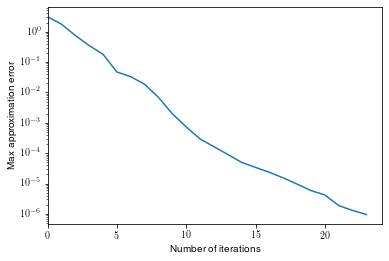

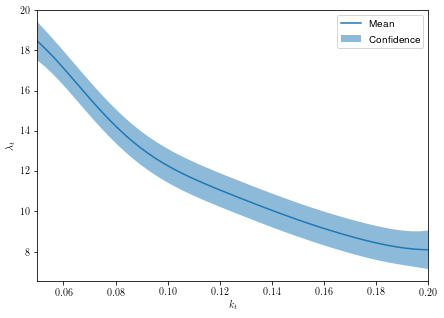

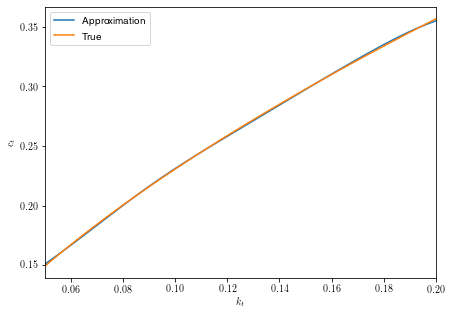

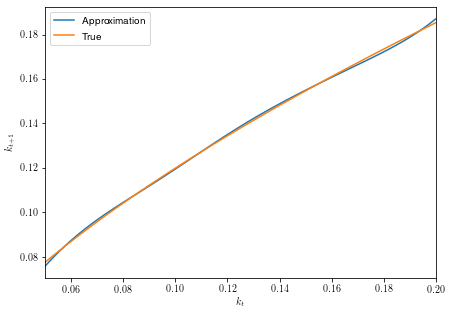

In [13]:
# --------------------------------------------------------------------------- #
# Plot
# --------------------------------------------------------------------------- #
# Approximation error
plt.plot(epsilons)
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel("Max approximation error")
plt.xlim([0, None])
plt.show()

# Turn on the evaluation mode to plot the policy functinos
gp_lambd_star.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_x = torch.linspace(kbeg, kend, 50, dtype=torch.float64)
    observed_pred = likelihood(gp_lambd_star(plot_x))
    lambd_star_mu = observed_pred.mean.numpy()
    lower_lambd, upper_lambd = observed_pred.confidence_region()
    ls_star = (((1-alpha) * A * plot_x.numpy()**alpha) / (psi*theta))**(
        1 / (theta+alpha-1))
    c_star = 1 / lambd_star_mu + psi * ls_star**theta
    kplus_star = A * plot_x.numpy()**alpha*ls_star**(1-alpha) - c_star

with torch.no_grad():
    # Initialize plot for c_star
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # Plot the predicted mean
    ax.plot(plot_x.numpy(), lambd_star_mu, label=r'Mean')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower_lambd.numpy(), upper_lambd.numpy(),
                    alpha=0.5, label=r'Confidence')
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$\lambda_{t}$")
    ax.legend(loc='best')
    plt.show()

    # Initialize plot for c_star
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    ax.plot(plot_x.numpy(), c_star, label=r'Approximation')
    ax.plot(plot_x.numpy(), c_compute_analytic(plot_x.numpy()), label=r'True')
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$c_{t}$")
    ax.legend(loc='best')
    plt.show()

    # Initialize plot for kplus_star
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    ax.plot(plot_x.numpy(), kplus_star, label=r'Approximation')
    ax.plot(plot_x.numpy(), kplus_compute_analytic(plot_x.numpy()),
            label=r'True')
    ax.set_xlim([kbeg, kend])
    # ax.set_ylim([-4, 4])
    ax.set_xlabel(r"$k_{t}$")
    ax.set_ylabel(r"$k_{t+1}$")
    ax.legend(loc='best')
    plt.show()